### Revised TRAPPIST-1 Evolution Simulation

#### Sim Setup
Planetary parameters taken from the NASA Exoplanet Archive, based on Agol 2021.

In [ ]:
import rebound
import reboundx
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from time import time
from IPython.display import display
from copy import deepcopy
from astropy import constants as const
from astropy import units as u
import warnings
warnings.filterwarnings('ignore')

# Unit conversions
AU = u.AU.to(u.cm)    # in cm
Msun = u.Msun.to(u.g) # in grams
yr = u.yr.to(u.s)     # in s

# Create the simulation
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')
sim.integrator = "whfast"
sim.random_seed = 13741154 # for reproducibility

# Add the star
M_star = 0.09
sim.add(m=M_star)

# Define planet radii
r_earth = 4.264e-5 # in AU
r_vals = np.array([1.116, 1.097, 0.788, 0.920, 1.045, 1.129, 0.755]) * r_earth

# Define planet masses
m_earth = 3.003e-6 # in solar masses
m_vals = np.array([1.374, 1.308, 0.388, 0.692, 1.039, 1.321, 0.326]) * m_earth

e0 = np.array([0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004])

# planet_names = ['b', 'c', 'd', 'e', 'f', 'g', 'h']
planet_names = ['b', 'c', 'd']
num_planets = len(planet_names) # limits number of planets
r_vals = r_vals[:3]
m_vals = m_vals[:3] 
e0 = e0[:3]

a_b = 0.1 # initial semimajor axis of b

# Draw initial ratios from log normal
initial_P_ratios = np.random.lognormal(0.703, 0.313, size=num_planets-1)
print("Initial period ratios:")
print(initial_P_ratios)

P_b = a_b**(3/2)
P_c = P_b * 3/2 * initial_P_ratios[0]
P_d = P_c * 3/2 * initial_P_ratios[1]
P0 = np.array([P_b, P_c, P_d])
a0 = P0**(2/3)

print("Initial semimajor axis values:")
print(a0)

# Add planets 
for i in range(num_planets):
    sim.add(m=m_vals[i], a=a0[i], e=e0[i])

# Move to center of momentum
sim.move_to_com()
ps = sim.particles
planets = ps[1:] # for easier indexing

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (mr_forecast.py, line 62)

#### Sim Params
Based on section 2.1 in Keller et al. (2026).

In [123]:
def get_taus(a_vals, m_vals, M_star, h, Sigma, alpha=1.5):
    '''
    Computes damping timescales based on current semimajor axis values.
    
    Parameters:
        a_vals: 1D NumPy array of current semimajor axis values.
    
    Returns:
        tau_a: semimajor axis damping timescale.
        tau_e: eccentricity damping timescale.
    '''
    tau_a = (1/(2.7+1.1*alpha)) * (M_star/m_vals) * (M_star/(Sigma*a_vals**2)) * (h**2 / np.sqrt(const.G*M_star/a_vals**3))
    tau_e = (1/0.780) * (M_star/m_vals) * (M_star/(Sigma*a_vals**2)) * (h**4 / np.sqrt(const.G*M_star/a_vals**3))
    return tau_a, tau_e

def get_Sigma(a_vals, Sigma_1au, alpha=1.5):
    return Sigma_1au * a_vals**(-alpha)

def get_h(K, alpha=1.5):
    return np.sqrt(0.780/(2.7+1.1*alpha)/K)

def get_Sigma(Sigma_1au, a_vals, alpha=1.5):
    return Sigma_1au * (a_vals**-alpha)

# Draw surface density at 1au from log uniform
Sigma_1au = scipy.stats.loguniform.rvs(a=10, b=10000, size=1) # in g/cm^2
Sigma_1au *= AU**2 / Msun # unit conversion for sim
print(f"Sigma_1au: {float(Sigma_1au):.4g}")

# Draw K-factor from log uniform and solve for h
K = scipy.stats.loguniform.rvs(a=10, b=1000, size=1)
h = get_h(K) # here, h = h_1au since there is no flaring
print(f"h_1au: {float(h):.4g}")
print(f"tau_a of b: {get_taus(a_b, m_vals, M_star, h, get_Sigma(Sigma_1au, a_b))[0][0].value:.4e}")

Sigma_1au: 0.0002756
h_1au: 0.04668
tau_a of b: 1.4560e+08


#### Handling Close Encounters
Symplectic integrators are not designed to handle close encounters, so we discard sims where planets ventured within five mutual Hill radii of each other.

In [ ]:
def get_hill_radius(m1, a1, m2, a2, M_star):
    return ((m1+m2)/(3*M_star))**1/3 * (a1+a2)/2

#### Implementing REBOUNDx forces


In [ ]:
rebx = reboundx.Extras(sim)
mig = rebx.load_force("type_I_migration")
rebx.add_force(mig)

mig.params["tIm_scale_height_1"] = h # = h_1au
mig.params["tIm_surface_density_1"] = Sigma_1au
mig.params["tIm_surface_density_exponent"] = 1.5 # alpha
mig.params["tIm_flaring_index"] = 0 # beta

mig.params["ide_position"] = 0.05 # inner disk edge
mig.params["ide_width"] = 0.01
print('Planet will stop within {0:.3f} AU of the inner disk edge at {1} AU'.format(mig.params["ide_width"], mig.params["ide_position"]))

Planet will stop within 0.010 AU of the inner disk edge at 0.05 AU


#### Data storage
For every `sim.dt`, the simulation must update the time-scales ($\tau_a$ and $\tau_e$). However, it is slow to record data at every such step. So, only certain times will be recorded and plotted in the end.

Note that the actual amount of time integrated is `t_spacing*n_out` $\approx$ `stage1_end`.

In [ ]:
sim.dt = planets[0].P / 20 # 1/20 of planet b

def data_df(n_out, times):        
    return pd.DataFrame({
        "time": times,
        "a": np.zeros(n_out),
        "e": np.zeros(n_out),
        "P": np.zeros(n_out),
        "P_ratio": np.zeros(n_out),
        "tau_a": np.zeros(n_out),
        "tau_e": np.zeros(n_out)
    })

# Set up times for integration & data collection
stage1_end = 100000 # yrs
n_out = 5000 # number of data points to collect

stage1_times = np.linspace(0, stage1_end, n_out)  # all times to integrate over
stage1_data = {name : data_df(n_out, stage1_times) for name in planet_names[:num_planets]}

#### It's time to integrate

$\tau_a$ and $\tau_e$ must be updated with `sim.dt`. We can also choose which planets to apply Type I migration on.

In [ ]:
tstart = time()
stop_sim = False

for i, t in enumerate(stage1_times):  
    sim.integrate(t)
    
    current_a_vals = np.array([p.a for p in sim.particles[1:]])
    
    for p in range(num_planets):
        name = planet_names[p]
        stage1_data[name]["a"][i] = planets[p].a
        stage1_data[name]["e"][i] = planets[p].e
        # stage1_data[name]["P"][i] = planets[p].P
        # stage1_data[name]["tau_a"][i] = tau_a[p]
        # stage1_data[name]["tau_e"][i] = tau_e[p]
        if p != num_planets-1: # don't record period ratio for last planet
            stage1_data[name]["P_ratio"][i] = planets[p+1].P / planets[p].P
            r_hill = get_hill_radius(m_vals[p], current_a_vals[p], m_vals[p+1], current_a_vals[p+1], M_star)
            # Stop sim if within 5 r_hill (TODO)
            
        # Stop sim if planet goes into star
        if planets[p].a < 0.001:
            stop_sim = True
    
    if stop_sim:
        print(f"Stopped integration at t={t}")
        break
        
print(f'finished integration in {time()-tstart:.4} sec')

finished integration in 15.26 sec


#### Plot it!

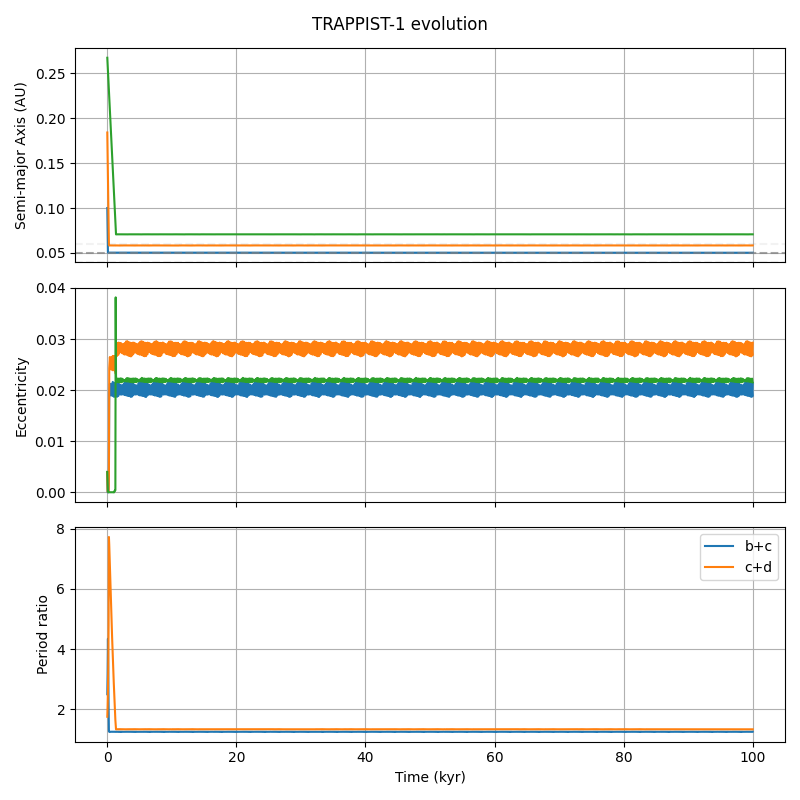

In [ ]:
%matplotlib widget

def plot_trappist1():
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
    fig.set_figwidth(8)
    fig.set_figheight(8)

    for p in range(num_planets):
        # could also try plotting log
        name = planet_names[p]
        ax1.plot(stage1_times/1000, stage1_data[name]["a"], label=name)
        ax2.plot(stage1_times/1000, stage1_data[name]["e"], label=name)
        if p != num_planets-1:
            ax3.plot(stage1_times/1000, stage1_data[name]["P_ratio"], label=f"{name}+{planet_names[p+1]}")
        # ax4.plot(stage1_times/1000, stage1_data[name]["tau_a"], label=name)
        # ax5.plot(stage1_times/1000, stage1_data[name]["tau_a"], label=name)
        
    plt.xlabel("Time (kyr)")
    ax1.set_ylabel("Semi-major Axis (AU)")
    ax2.set_ylabel("Eccentricity")
    ax3.set_ylabel("Period ratio")
    # ax4.set_ylabel("tau_a")
    # ax5.set_ylabel("tau_e")
    
    # ax1.set_ylim(0,0.45)
    # ax2.set_ylim(-0.1,0.45)
    # ax3.set_ylim(0,2.1)
    # ax4.set_ylim(-10000, 0)s
    # ax5.set_ylim(-10000, 0)
    
    # Plot ide location & width
    ax1.axhline(mig.params["ide_position"], color='gray', ls='--', alpha=0.7)
    ax1.axhline(mig.params["ide_position"] - mig.params["ide_width"], color='gray', ls='--', alpha=0.1)
    ax1.axhline(mig.params["ide_position"] + mig.params["ide_width"], color='gray', ls='--', alpha=0.1)

    fig.subplots_adjust(hspace=0)

    plt.suptitle("TRAPPIST-1 evolution")
    ax1.grid(True); ax2.grid(True); ax3.grid(True); # ax4.grid(True)
    plt.legend(); plt.tight_layout(); plt.show()

plot_trappist1()